In [1]:
import pandas as pd
import numpy as np
from copy import copy
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


# Model

In [2]:
class Model:
    
    def __init__(self, dataframe, target_name, type='regression', index=None):
        self.target_name = target_name
        if index:
            self.dataframe = dataframe.set_index(index)
        else:
            self.dataframe = dataframe
        self.type = type

    def split_dataframe(self, train_size):
        '''Splits the dataframe, required to apply the models'''
        X = self.dataframe.drop(columns=self.target_name)
        y = self.dataframe[self.target_name]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, train_size=train_size, random_state=43)
    
    def apply_models(self, selection=None, params=None):
        '''Applies every selected model, all of them if none is selected'''
        self.models_regression = {'LinearRegression': LinearRegression(), 'Ridge': Ridge()}
        self.models_classification = {'LogisticRegression': LogisticRegression()}
        if self.type == 'regression':
            self.models = copy(self.models_regression)
        elif self.type == 'classification':
            self.models = copy(self.models_classification)
        self.models_previous = self.models.copy()
        if selection:
            for element in self.models_previous.keys():
                if element not in selection:
                    self.models.pop(element)
        if params:
            self.models[params[0]] = eval(params[0] + '(' + params[1] + ')')
            self.models[params[0] + ': ' + params[1]] = self.models.pop(params[0])
        for model_name, model in self.models.items():
            model.fit(self.X_train, self.y_train)
            self.y_pred = model.predict(self.X_test)
            self.models[model_name] = {'test': np.array(self.y_test), 'prediction': self.y_pred}
        return self.models

    def evaluate_metrics(self, selection=None):
        '''Anotates regression metrics based on the real values and the predicion'''
        self.models_evaluated_previous = self.models
        self.models_evaluated = copy(self.models_evaluated_previous)
        if selection:
            for element in self.models_evaluated_previous.keys():
                if element not in selection:
                    self.models_evaluated.pop(element)
        if self.type == 'regression':
            for model_name, model_results in self.models_evaluated.items():
                rmse = mean_squared_error(model_results['test'], model_results['prediction'], squared=False)
                mse = mean_squared_error(model_results['test'], model_results['prediction'])
                mae = mean_absolute_error(model_results['test'], model_results['prediction'])
                r2 = r2_score(model_results['test'], model_results['prediction'])
                mape = mean_absolute_percentage_error(model_results['test'], model_results['prediction'])
                self.models_evaluated[model_name]['metrics'] = {'rmse': rmse, 'mse': mse, 'mae': mae, 'r2_score': r2, 'mape': mape}
        elif self.type == 'classification':
            for model_name, model_results in self.models_evaluated.items():
                accuracy = accuracy_score(model_results['test'], model_results['prediction'])
                recall = recall_score(model_results['test'], model_results['prediction'])
                precision = precision_score(model_results['test'], model_results['prediction'])
                confusion = confusion_matrix(model_results['test'], model_results['prediction'])
                diagonal_total = 0
                for index, element in enumerate(confusion):
                    diagonal_total += element[index]
                f1 = f1_score(model_results['test'], model_results['prediction'])
                self.models_evaluated[model_name]['metrics'] = {'accuracy': accuracy, 'recall': recall, 'precision': precision, 'confusion_diagonal': diagonal_total, 'f1_score': f1}
        return self.models_evaluated

    def create_dataframe(self):
        '''Returns a dataframe with the metrics of each model'''
        self.models_metrics = self.models_evaluated.copy()
        for model_name, model_results in self.models_evaluated.items():
            self.models_metrics[model_name] = self.models_metrics[model_name]['metrics']
        df = pd.DataFrame(data=self.models_metrics)
        return df


In [3]:
df_train = pd.read_csv(r'..\data\processed\diamonds_train_1.csv').set_index('id')
X_pred = pd.read_csv(r'..\data\processed\diamonds_test_1.csv').set_index('id')


In [4]:
model_regression = Model(df_train, 'price')


In [5]:
model_regression.dataframe.head()


,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
id,,,,,,,,,,
0,0.30,3.0,6.0,1.0,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,4.0,5.0,5.0,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,4.0,4.0,3.0,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,2.0,3.0,1.0,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,3.0,3.0,4.0,62.3,59.0,4.50,4.55,2.82,6.588


In [6]:
model_regression.target_name


'price'

In [7]:
model_regression.split_dataframe(0.7)

model_regression.apply_models(params=['LinearRegression', 'fit_intercept=False'])


{'Ridge': {'test': array([8.069, 9.093, 8.297, ..., 9.234, 8.818, 8.368]),
  'prediction': array([8.17680573, 8.94804384, 7.94639017, ..., 9.13413924, 8.78223723,
         8.2264771 ])},
 'LinearRegression: fit_intercept=False': {'test': array([8.069, 9.093, 8.297, ..., 9.234, 8.818, 8.368]),
  'prediction': array([8.10340573, 8.92074906, 7.95995322, ..., 9.07862236, 8.73177353,
         8.17733816])}}

In [8]:
evaluated = model_regression.evaluate_metrics()

evaluated['Ridge']


{'test': array([8.069, 9.093, 8.297, ..., 9.234, 8.818, 8.368]),
 'prediction': array([8.17680573, 8.94804384, 7.94639017, ..., 9.13413924, 8.78223723,
        8.2264771 ]),
 'metrics': {'rmse': 0.22242364067242987,
  'mse': 0.049472275929978195,
  'mae': 0.12254797125895808,
  'r2_score': 0.9527452852542134,
  'mape': 0.015826828058058864}}

In [9]:
evaluated['LinearRegression: fit_intercept=False']['metrics']


{'rmse': 0.22216605222921373,
 'mse': 0.04935775476311372,
 'mae': 0.1287145841389296,
 'r2_score': 0.9528546730875161,
 'mape': 0.01663789691922508}

In [10]:
model_regression.create_dataframe()


,Ridge,LinearRegression: fit_intercept=False
rmse,0.222424,0.222166
mse,0.049472,0.049358
mae,0.122548,0.128715
r2_score,0.952745,0.952855
mape,0.015827,0.016638


In [11]:
X = load_wine(as_frame=True).data
y = load_wine(as_frame=True).target

df = X.join(y)

df = df.drop(df[df['target'] ==0].index)

df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
59,12.37,0.94,1.36,10.6,88.0,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520.0,1
60,12.33,1.10,2.28,16.0,101.0,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680.0,1
61,12.64,1.36,2.02,16.8,100.0,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450.0,1
62,13.67,1.25,1.92,18.0,94.0,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630.0,1
63,12.37,1.13,2.16,19.0,87.0,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420.0,1


In [12]:
model_classification = Model(df, 'target', type='classification')

In [13]:
model_classification.split_dataframe(0.7)

model_classification.apply_models()


c:\Users\Roger\AppData\Local\miniconda3\envs\data_analytics\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'LogisticRegression': {'test': array([1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1,
         1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2]),
  'prediction': array([1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1,
         2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2])}}

In [14]:
evaluated = model_classification.evaluate_metrics()

evaluated['LogisticRegression']


{'test': array([1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1,
        1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2]),
 'prediction': array([1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1,
        2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2]),
 'metrics': {'accuracy': 0.9444444444444444,
  'recall': 0.9090909090909091,
  'precision': 1.0,
  'confusion_diagonal': 34,
  'f1_score': 0.9523809523809523}}

In [15]:
model_classification.create_dataframe()


,LogisticRegression
accuracy,0.944444
confusion_diagonal,34.000000
f1_score,0.952381
precision,1.000000
recall,0.909091


In [16]:
df_diamonds = pd.read_csv(r'..\data\raw\train.csv')

df_diamonds.rename(columns={'carat': 'weight (carat)',
                    'cut': 'cut quality',
                    'color': 'color quality',
                    'clarity': 'clarity quality', 
                    'depth': 'depth (percentage)', 
                    'table': 'table (percentage)',
                    'x': 'lenght (millimeters)', 
                    'y': 'width (millimeters)',
                    'z': 'depth (millimeters)'
                    }, inplace=True
            )
df_diamonds.head()


,id,weight (carat),cut quality,color quality,clarity quality,depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


# Data cleansing

In [17]:
df_train = pd.read_csv(r'..\data\raw\train.csv')
df_test = pd.read_csv(r'..\data\raw\test.csv')

df_diamonds = [df_train, df_test]

for df in df_diamonds:
    df.rename(columns={'carat': 'weight (carat)',
                         'depth': 'depth (percentage)', 
                        'table': 'table (percentage)', 
                        'x': 'lenght (millimeters)', 
                        'y': 'width (millimeters)', 
                        'z': 'depth (millimeters)' 
                        }, inplace=True
                )
    df.drop(columns=['cut', 'color', 'clarity'], inplace=True)

df_diamonds[0].head()


,id,weight (carat),depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
0,0,0.30,62.4,58.0,4.31,4.28,2.68,6.353
1,1,1.01,62.7,56.0,6.42,6.46,4.04,9.183
2,2,0.72,61.8,59.0,5.71,5.74,3.54,7.983
3,3,1.08,63.2,57.0,6.54,6.50,4.12,8.371
4,4,0.36,62.3,59.0,4.50,4.55,2.82,6.588


In [18]:
class Data_cleansing:

    def __init__(self, dataframes, target_name, index=None):
        self.train = dataframes[0]
        self.test = dataframes[1]
        self.target_name = target_name
        self.target = self.train[target_name]
        if index:
            self.train = self.train.set_index(index)
            self.test = self.test.set_index(index)

    def impute_boxplot_min_max(self, list_of_columns, min=True, max=True):
        '''Imputes the outliers of a boxplot for the chosen columns to its min and max values'''
        for column in list_of_columns:
            q3, q1 = np.percentile(self.train[column], [75, 25])
            iqr = q3 - q1
            if min:
                self.train.loc[self.train[column] < q1 - 1.5*iqr, column] = q1 - 1.5*iqr
            if max:
                self.train.loc[self.train[column] > q3 + 1.5*iqr, column] = q3 + 1.5*iqr
        return self.train

    def remove_elements(self, conditioned_columns_list, condition, number):
        '''Removes the rows of a dataframe based on a condition'''
        for column in conditioned_columns_list:
            if condition == 'equal':
                self.train.drop(self.train[(self.train[column] == number)].index, inplace=True)
            elif condition == 'bigger':
                self.train.drop(self.train[(self.train[column] > number)].index, inplace=True)
            elif condition == 'bigger_or_equal':
                self.train.drop(self.train[(self.train[column] >= number)].index, inplace=True)   
            elif condition == 'smaller':
                self.train.drop(self.train[(self.train[column] < number)].index, inplace=True)   
            elif condition == 'smaller_or_equal':
                self.train.drop(self.train[(self.train[column] <= number)].index, inplace=True)
            return self.train

    def apply_scalar(self, method, list_of_columns=None):
        '''Applies the selected scalar method to a list of train and test dataframes for the chosen columns'''
        if method == 'log' and list_of_columns:
            for df in (self.train, self.test):
                for column in list_of_columns:
                    df[column] = np.log(df[column])
        elif method == 'standard':
            scaler = StandardScaler().fit(self.train.values)
            self.test = self.test.join(self.target)
            for df in (self.train, self.test):
                df.loc[:, :] = scaler.transform(df.values)
            self.test = self.test.drop(columns=self.target_name)
        return (self.train, self.test)
    

In [19]:
clean = Data_cleansing(df_diamonds, 'price', index='id')

clean.train.head()


,weight (carat),depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
id,,,,,,,
0,0.30,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,62.3,59.0,4.50,4.55,2.82,6.588


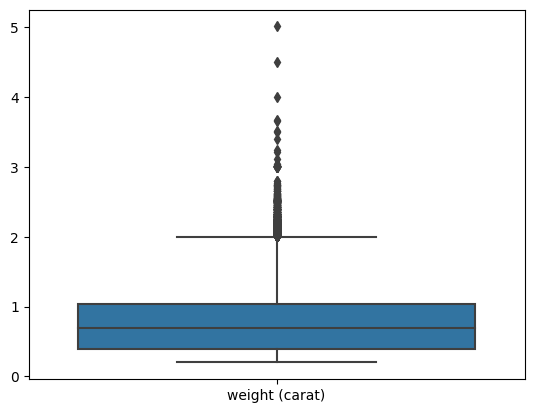

In [20]:
ax = sns.boxplot(df_diamonds[0]['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


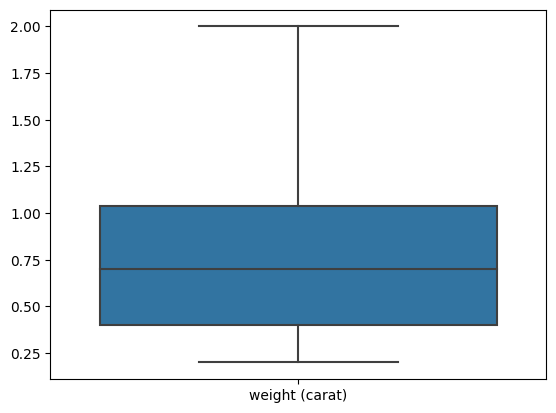

In [21]:
df = clean.impute_boxplot_min_max(['weight (carat)'])

ax = sns.boxplot(df['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


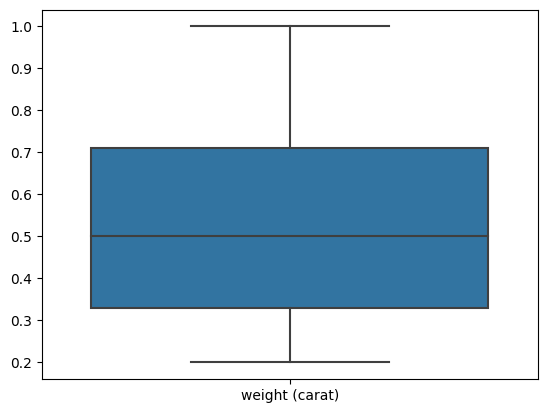

In [22]:
df = clean.remove_elements(['weight (carat)'], 'bigger', 1)

ax = sns.boxplot(df['weight (carat)'])
ax.set_xticklabels(['weight (carat)'])
plt.show()


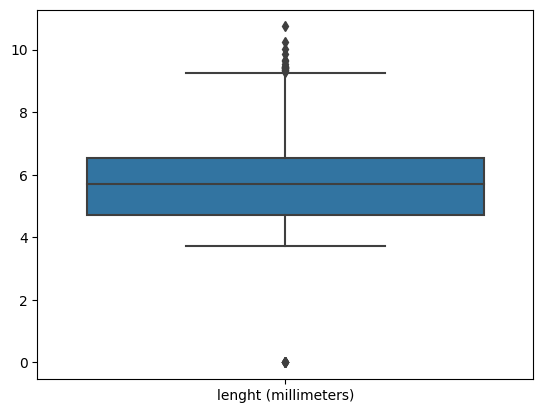

In [23]:
ax = sns.boxplot(df_diamonds[0]['lenght (millimeters)'])
ax.set_xticklabels(['lenght (millimeters)'])
plt.show()


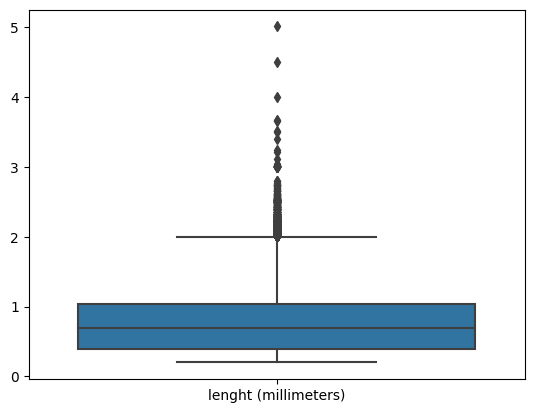

In [24]:
ax = sns.boxplot(df_diamonds[0]['weight (carat)'])
ax.set_xticklabels(['lenght (millimeters)'])
plt.show()

In [25]:
clean.apply_scalar('log', ['weight (carat)'])[0].head()


,weight (carat),depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
id,,,,,,,
0,-1.203973,62.4,58.0,4.31,4.28,2.68,6.353
2,-0.328504,61.8,59.0,5.71,5.74,3.54,7.983
4,-1.021651,62.3,59.0,4.50,4.55,2.82,6.588
5,-0.634878,61.4,57.0,5.18,5.20,3.19,7.496
7,-1.108663,60.0,56.0,4.53,4.56,2.72,6.877


In [26]:
clean.apply_scalar('standard')[0].head()


,weight (carat),depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters),price
id,,,,,,,
0,-1.211593,0.471942,0.331925,-1.155202,-1.183654,-1.025338,-1.255138
2,0.963464,0.039654,0.776671,0.890033,0.902371,0.840906,1.069777
4,-0.758625,0.399894,0.776671,-0.877635,-0.797882,-0.721531,-0.919951
5,0.202293,-0.248538,-0.112821,0.115765,0.130827,0.081388,0.375155
7,-0.974800,-1.257211,-0.557567,-0.833808,-0.783594,-0.938536,-0.507742


In [27]:
clean.test

,weight (carat),depth (percentage),table (percentage),lenght (millimeters),width (millimeters),depth (millimeters)
id,,,,,,
0,-1.051251,-0.896971,0.331925,-0.979896,-0.883609,-0.981937
1,2.314049,0.832182,1.221417,2.482395,2.331155,2.403343
2,3.038778,0.183750,0.776671,3.578057,3.559909,3.358165
3,1.064884,-0.824923,-0.557567,1.226036,1.130976,0.949408
4,2.786973,2.201095,-1.002313,3.154401,2.916956,3.293064
...,...,...,...,...,...,...
13480,2.016409,-1.545403,1.221417,2.394742,2.274004,1.839129
13481,1.517853,0.255798,1.221417,1.518213,1.559612,1.470221
13482,-1.211593,0.255798,-1.758381,-1.169811,-1.126502,-1.025338
